In [11]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import math
import os
from sklearn.cluster import KMeans

In [12]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

def rotate_tuple(point, angle_degrees):
    """
    Rotates a 2D tuple (point) by a given angle in degrees.

    Args:
        point: A tuple (x, y).
        angle_degrees: Angle to rotate the point, in degrees.

    Returns:
        A tuple (x', y') representing the rotated point.
    """
    # Convert angle to radians
    angle_radians = math.radians(angle_degrees)

    # Extract the x and y coordinates
    x, y = point

    # Apply the rotation matrix
    x_rotated = x * math.cos(angle_radians) - y * math.sin(angle_radians)
    y_rotated = x * math.sin(angle_radians) + y * math.cos(angle_radians)

    return (x_rotated, y_rotated)

def multiply_tuple(point, scale):
    return tuple(element * scale for element in point)

def add_tuple(x, y):
    return (x[0] + y[0], x[1] + y[1])




In [13]:
def is_point_in_rectangle(p, rect):

    def vector(a, b):
        return (b[0] - a[0], b[1] - a[1])
    
    def dot_product(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]
    
    def magnitude_squared(v):
        return v[0]**2 + v[1]**2
    
    # Unpack rectangle vertices
    A, B, C, D = rect
    
    # Compute vectors
    AB = vector(A, B)
    AD = vector(A, D)
    AP = vector(A, p)
    
    # Check if the point projects within both sides of the rectangle
    within_AB = 0 <= dot_product(AP, AB) <= magnitude_squared(AB)
    within_AD = 0 <= dot_product(AP, AD) <= magnitude_squared(AD)
    
    return within_AB and within_AD

In [14]:
#draw functions


def plot_images(image_paths):

    images = [cv.imread(p) for p in image_paths]

    # Check if the list is empty
    if not images:
        raise ValueError("The list of images is empty.")
    
    # Find the maximum height among all images
    max_height = max(img.shape[0] for img in images)
    
    # Resize all images to have the same height
    resized_images = [
        cv.resize(img, (int(img.shape[1] * max_height / img.shape[0]), max_height))
        for img in images
    ]
    
    # Horizontally concatenate images
    concatenated_image = np.hstack(resized_images)
    print([os.path.split(p)[-1] for p in image_paths])
    plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))
    plt.title("models")
    plt.show()

def draw_good_and_bad_matches(scene, good, bad, kp_scene):
#draw excluded and included matches
        for o in bad:
            x,y = kp_scene[o.trainIdx].pt
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,0,255), 2)

        for o in good:
            x,y = kp_scene[o.trainIdx].pt  # Get match coordinates
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,255,0), 2)

        plt.imshow(cv.cvtColor(scene, cv.COLOR_BGR2RGB))
        plt.title("grid with good and bad (excluded) matches")
        plt.show()

def draw_matches(model, kp_model, scene, kp_scene, good):
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                        singlePointColor = None, # not draw keypoints only matching lines
                        matchesMask = None, # draw only inliers
                        flags = 2) # not draw keypoints only lines
    img3 = cv.drawMatches(model, kp_model, scene, kp_scene, good, None,**draw_params)
    plt.title("Correlating matches")
    plt.imshow(img3)
    plt.show()

def draw_barycenter_predictions(scene, barygrid_cell_width, barygrid_cell_height, barycenter_votes, dst_kp):
    

    for b, d in zip(barycenter_votes, dst_kp):
        d = [int(d.pt[0]), int(d.pt[1])]
        cv.circle(scene, d, 3, (0,255,0), 2)
        cv.circle(scene, b, 3, (255,0,0), 2)
        cv.line(scene, d, b, color=(0, 255, 0), thickness=1)
    
    height, width, _ = scene.shape
    num_vertical_lines = width // barygrid_cell_width
    num_horizontal_lines = height // barygrid_cell_height
    
    for i in range(1, num_vertical_lines):
        x = i * barygrid_cell_width
        cv.line(scene, (x, 0), (x, height), color=(0, 0, 255), thickness=1)

    for i in range(1, num_horizontal_lines+1):
        y = i * barygrid_cell_height
        cv.line(scene, (0, y), (width, y), color=(0, 0, 255), thickness=1)

    plt.imshow(cv.cvtColor(scene, cv.COLOR_BGR2RGB))
    plt.title("predicted barycenteres aka votes (in blue)")
    plt.show()

In [15]:
def uniform_grid_sampling_with_descriptors(image, keypoints, descriptors, rows=4, cols=4, top_k=5):
    """
    Performs uniform grid sampling on keypoints and descriptors.

    Args:
        image: The input image (used for determining dimensions).
        keypoints: List of keypoints detected in the image.
        descriptors: Corresponding descriptors for the keypoints.
        rows: Number of rows to divide the image into.
        cols: Number of columns to divide the image into.
        top_k: Maximum number of keypoints/descriptors to keep per grid cell.

    Returns:
        filtered_keypoints: List of filtered keypoints.
        filtered_descriptors: Numpy array of filtered descriptors.
    """
    height, width = image.shape[:2]
    cell_height = height // rows
    cell_width = width // cols

    filtered_keypoints = []
    filtered_descriptors = []

    for i in range(rows):
        for j in range(cols):
            # Define the boundaries of the current grid cell
            x_start, y_start = j * cell_width, i * cell_height
            x_end, y_end = x_start + cell_width, y_start + cell_height

            # Select keypoints within this cell
            cell_keypoints = [(kp, idx) for idx, kp in enumerate(keypoints)
                              if x_start <= kp.pt[0] < x_end and y_start <= kp.pt[1] < y_end]

            # Sort keypoints in the cell by response value
            cell_keypoints = sorted(cell_keypoints, key=lambda kp_idx: kp_idx[0].response, reverse=True)[:top_k]

            # Keep the top_k keypoints and their corresponding descriptors
            for kp, idx in cell_keypoints:
                filtered_keypoints.append(kp)
                filtered_descriptors.append(descriptors[idx])

    # Convert the filtered descriptors to a numpy array
    filtered_descriptors = np.array(filtered_descriptors)

    return filtered_keypoints, filtered_descriptors


In [16]:
def calculate_enclosed_pixels(points):
    # Convert points to a numpy array with the appropriate shape
    polygon = np.array([points], dtype=np.int32)

    x_min = min(point[0] for point in points)
    x_max = max(point[0] for point in points)
    y_min = min(point[1] for point in points)
    y_max = max(point[1] for point in points)

    mask = np.zeros((y_max - y_min + 1, x_max - x_min + 1), dtype=np.uint8)

    adjusted_polygon = polygon - [x_min, y_min]

    cv.fillPoly(mask, [adjusted_polygon], 255)

    num_pixels = np.count_nonzero(mask)

    """
    plt.figure()
    plt.imshow(mask, cmap='gray', origin='lower')
    plt.title("Enclosed Pixels in the Quadrilateral")
    plt.scatter(
        [p[0] - x_min for p in points], 
        [p[1] - y_min for p in points], 
        color="red", label="Vertices"
    )
    plt.plot(
        [p[0] - x_min for p in points + [points[0]]], 
        [p[1] - y_min for p in points + [points[0]]], 
        color="blue", label="Edges"
    )
    plt.legend()
    plt.show()
    """

    return num_pixels

Looking in m1.png
m1.png
['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']


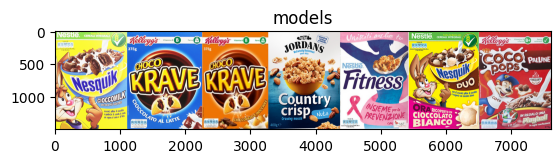

Looking for 0.jpg...
number of total matches: 8081
number of good matches: 214
Enough matches are found!
Enough Votes for (16,3):55
enclosed pixels: 85637
enclosed pixels ratio: 1557.0363636363636
Looking for 1.jpg...
number of total matches: 3192
number of good matches: 79
Not enough matches are found - 79/80
Looking for 11.jpg...
number of total matches: 353
number of good matches: 9
Not enough matches are found - 9/80
Looking for 19.jpg...
number of total matches: 1375
number of good matches: 9
Not enough matches are found - 9/80
Looking for 24.jpg...
number of total matches: 1065
number of good matches: 212
Enough matches are found!
Enough Votes for (3,4):72
Enough Votes for (3,5):35
Enough Votes for (9,4):24
Enough Votes for (9,5):23
Enough Votes for (10,4):23
enclosed pixels: 175911
enclosed pixels ratio: 2443.2083333333335
ignore!
enclosed pixels: 164617
enclosed pixels ratio: 6859.041666666667
Bad detected area / #pixels ratio!
ignore!
ignore!
Looking for 26.jpg...
number of to

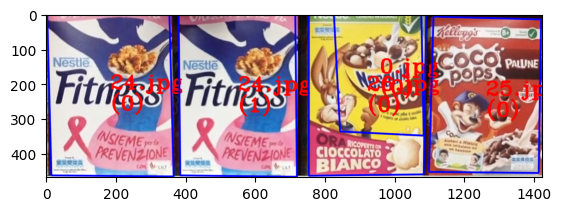

Looking in m2.png
m2.png
['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']


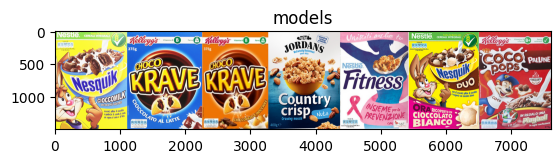

Looking for 0.jpg...
number of total matches: 8081
number of good matches: 411
Enough matches are found!
Enough Votes for (3,5):270
Enough Votes for (3,6):16
enclosed pixels: 154734
enclosed pixels ratio: 573.0888888888888
ignore!
Looking for 1.jpg...
number of total matches: 3192
number of good matches: 149
Enough matches are found!
Enough Votes for (9,4):19
Enough Votes for (15,4):25
Enough Votes for (21,4):22
enclosed pixels: 122307
enclosed pixels ratio: 6437.210526315789
Bad detected area / #pixels ratio!
enclosed pixels: 129057
enclosed pixels ratio: 5162.28
Bad detected area / #pixels ratio!
enclosed pixels: 121791
enclosed pixels ratio: 5535.954545454545
Bad detected area / #pixels ratio!
Looking for 11.jpg...
number of total matches: 353
number of good matches: 68
Not enough matches are found - 68/80
Looking for 19.jpg...
number of total matches: 1375
number of good matches: 12
Not enough matches are found - 12/80
Looking for 24.jpg...
number of total matches: 1065
number of g

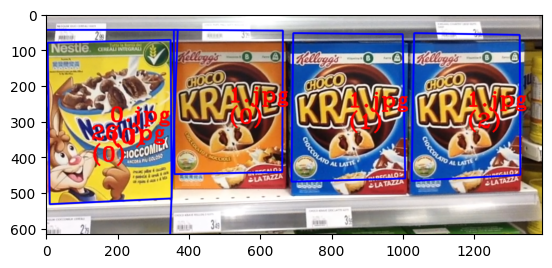

Looking in m3.png
m3.png
['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']


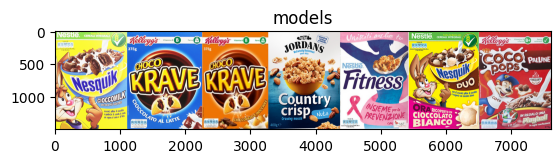

Looking for 0.jpg...
number of total matches: 8081
number of good matches: 132
Enough matches are found!
Enough Votes for (3,3):59
enclosed pixels: 92746
enclosed pixels ratio: 1571.9661016949153
Looking for 1.jpg...
number of total matches: 3192
number of good matches: 77
Not enough matches are found - 77/80
Looking for 11.jpg...
number of total matches: 353
number of good matches: 6
Not enough matches are found - 6/80
Looking for 19.jpg...
number of total matches: 1375
number of good matches: 205
Enough matches are found!
Enough Votes for (22,2):29
Enough Votes for (22,3):167
enclosed pixels: 113610
enclosed pixels ratio: 3917.5862068965516
Bad detected area / #pixels ratio!
ignore!
Looking for 24.jpg...
number of total matches: 1065
number of good matches: 14
Not enough matches are found - 14/80
Looking for 26.jpg...
number of total matches: 1134
number of good matches: 307
Enough matches are found!
Enough Votes for (3,4):276
enclosed pixels: 179184
enclosed pixels ratio: 649.217391

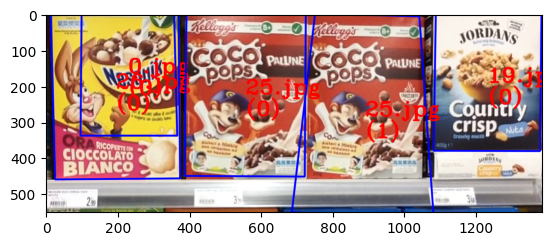

Looking in m4.png
m4.png
['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']


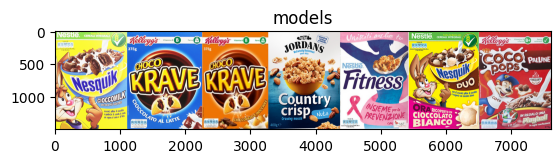

Looking for 0.jpg...
number of total matches: 8081
number of good matches: 147
Enough matches are found!
Enough Votes for (13,2):36
enclosed pixels: 86108
enclosed pixels ratio: 2391.8888888888887
Looking for 1.jpg...
number of total matches: 3192
number of good matches: 67
Not enough matches are found - 67/80
Looking for 11.jpg...
number of total matches: 353
number of good matches: 2
Not enough matches are found - 2/80
Looking for 19.jpg...
number of total matches: 1375
number of good matches: 4
Not enough matches are found - 4/80
Looking for 24.jpg...
number of total matches: 1065
number of good matches: 177
Enough matches are found!
Enough Votes for (2,3):79
Enough Votes for (7,3):74
enclosed pixels: 184356
enclosed pixels ratio: 2333.6202531645567
enclosed pixels: 174078
enclosed pixels ratio: 2352.4054054054054
Looking for 26.jpg...
number of total matches: 1134
number of good matches: 216
Enough matches are found!
Enough Votes for (12,3):142
Enough Votes for (13,3):66
enclosed p

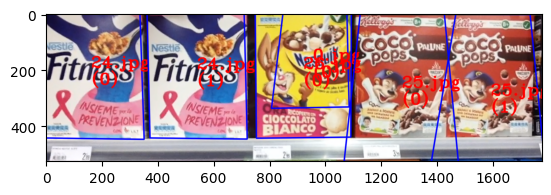

Looking in m5.png
m5.png
['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']


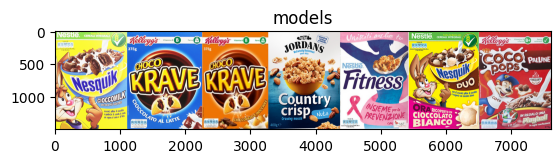

Looking for 0.jpg...
number of total matches: 8081
number of good matches: 101
Enough matches are found!
Looking for 1.jpg...
number of total matches: 3192
number of good matches: 153
Enough matches are found!
Enough Votes for (3,17):17
Enough Votes for (11,17):21
enclosed pixels: 120997
enclosed pixels ratio: 7117.470588235294
Bad detected area / #pixels ratio!
enclosed pixels: 130147
enclosed pixels ratio: 6197.476190476191
Bad detected area / #pixels ratio!
Looking for 11.jpg...
number of total matches: 353
number of good matches: 58
Not enough matches are found - 58/80
Looking for 19.jpg...
number of total matches: 1375
number of good matches: 193
Enough matches are found!
Enough Votes for (21,3):17
Enough Votes for (21,4):143
enclosed pixels: 115475
enclosed pixels ratio: 6792.64705882353
Bad detected area / #pixels ratio!
ignore!
Looking for 24.jpg...
number of total matches: 1065
number of good matches: 16
Not enough matches are found - 16/80
Looking for 26.jpg...
number of tota

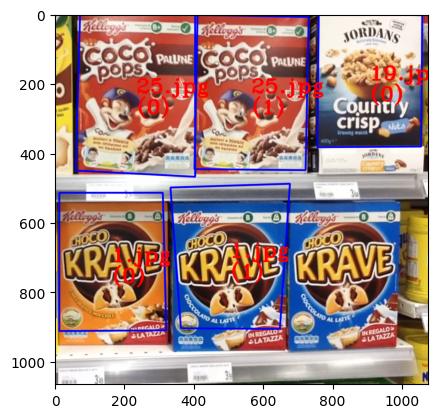

In [21]:
def find_image(scene_path, model_paths, draw_on_color=True, sharpen=False):
    target_resolution = (150,210) #(250, 350) # aspect ratio: 4.2/3 or 1.4/1
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    if sharpen:
        kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
        scene_gray = cv.filter2D(scene_gray, -1, kernel)

    scene_to_draw_on = cv.imread(scene_path) if draw_on_color else scene_gray

    #create array with all models
    models = []

    
    
    for model_gray_path in model_paths:

        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        print(f"Looking for {model["name"]}...")

        # Apply model preprocessing
        model_gray = model["img"]
        
        MIN_MATCH_COUNT = 80 #100

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des1 = sift.detectAndCompute(model_gray,None)
        kp_scene, des2 = sift.detectAndCompute(scene_gray,None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        print("number of total matches:", len(matches))

        # store all the good matches as per Lowe's ratio test.
        good = []
        bad = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
            else:
                bad.append(m)
        
        print("number of good matches:", len(good))

        scene_to_draw_on = scene_to_draw_on if scene_to_draw_on is not None else scene_gray

        result = scene_to_draw_on

        src_kp = [kp_model[m.queryIdx] for m in good]
        dst_kp = [kp_scene[m.trainIdx] for m in good]

        #draw_good_and_bad_matches(scene_to_draw_on.copy(), good, bad, kp_scene)

        #draw_matches(model_gray.copy(), kp_model, scene_to_draw_on.copy(), kp_scene, good)
        
    # Selection via Grid Feature Threshold
        THRESHOLD_GRIDS = 18

        # Define the dimensions of the target image
        h, w = model_gray.shape
        grid_size_x = 4  # Divide image into a grid (e.g., 5x5)
        grid_size_y = 5
        grid_matches = [[0] * grid_size_x for _ in range(grid_size_y)]

        for match in good:
            x, y = kp_model[match.queryIdx].pt  # Get match coordinates
            grid_x = int(x / (w / grid_size_x))
            grid_y = int(y / (h / grid_size_y))
            grid_matches[grid_y][grid_x] += 1

        # Count non-empty grid cells
        matched_grids = sum(1 for row in grid_matches for cell in row if cell > 0)

        

        if matched_grids >= THRESHOLD_GRIDS:
            pass
            #print("Valid match (well-distributed keypoints):", matched_grids)
        else:
            pass
            #print("False positive (poorly distributed keypoints):", matched_grids)
            #continue
        
        #selection via amount of cells with matches
        


        #if len(good)>=MIN_MATCH_COUNT:
        if len(good) > MIN_MATCH_COUNT:
            print("Enough matches are found!")
            #print( "Enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )

            #calculate barycenter of model
            x = 0
            y = 0
            for kp in src_kp:
                x_kp, y_kp = kp.pt
                x += x_kp
                y += y_kp
            barycenter = np.array([int(x/len(src_kp)), int(y/len(src_kp))])

            #draw barycenter
            tmp = model_gray.copy()
            #cv.circle(tmp, barycenter, 3, (0,0,255), 2)
            #plt.imshow(tmp)
            #plt.show()

            # calculate joining vectors of model
            joining_vectors = []
            for kp in src_kp:
                x, y = kp.pt
                v = barycenter - [int(x), int(y)]
                joining_vectors.append(v)

            barycenter_votes = []

            for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

                if jv is None:
                    raise Exception("there must be the same point in")

                jv_x, jv_y = jv

                pt_x, pt_y = d.pt
                delta_s = d.size/s.size

                #delta_phi = d.angle/s.angle
                delta_phi = d.angle - s.angle

                angle_radians = math.radians(delta_phi)
                jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
                jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

                bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
                barycenter_votes.append(bary_predict)


            GRID_RESOLUTION = 25
            MIN_VOTES = 15
            barygrid_cell_width = int(scene_gray.shape[1]/GRID_RESOLUTION)
            barygrid_cell_height = barygrid_cell_width

            number_barygrid_cells_y = int(scene_gray.shape[1]//barygrid_cell_height + 1)

            # Initialize a 2D array where each element is an empty list
            grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(number_barygrid_cells_y)]

            barygrid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(number_barygrid_cells_y)]

            # assign feature matches and barycenters to grids
            for i in range(0,len(barycenter_votes)):
                bary = barycenter_votes[i]
                # Check if predict Bary center is in Picture
                if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
                    x_idx = int(bary[0]/barygrid_cell_width)
                    y_idx = int(bary[1]/barygrid_cell_height)
                    #print((x_idx, y_idx))
                    grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
                    barygrid[x_idx][y_idx].append(bary)

            

            # select vote winners in grid
            barygrid_means = []
            winners = []
            for i in range(0,len(grid)):
                for j in range(0,len(grid[i])):
                    if len(grid[i][j])>MIN_VOTES:
                        print(f"Enough Votes for ({i},{j}):{len(grid[i][j])}")
                        winners.append(grid[i][j])
                        barygrid_means.append(np.mean(barygrid[i][j], axis=0))
                    else:
                        if len(grid[i][j])>10:
                            pass

            
            # draw barycenter predictions
            #draw_barycenter_predictions(scene_to_draw_on.copy(), barygrid_cell_width, barygrid_cell_height, barycenter_votes, dst_kp)
            
            i = 0

            ignored_area = []

            for winner, barygrid_mean in zip(winners, barygrid_means):

                in_already_recognized_area = False
                for rec in ignored_area:
                    if is_point_in_rectangle(barygrid_mean, rec):
                        in_already_recognized_area = True
                        break
                if in_already_recognized_area:
                    print("ignore!")
                    continue


                #USE THIS TO DRAW THE RESULTS FROM POINTS
                src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)

                

                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
                matchesMask = mask.ravel().tolist()
                h,w = model_gray.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,
                                                h-1],[w-1,0] ]).reshape(-1,1,2)

                dst = cv.perspectiveTransform(pts,M)
                corners = [o[0] for o in np.int32(dst)]
                print("enclosed pixels:", calculate_enclosed_pixels(corners))
                ratio = calculate_enclosed_pixels(corners)/len(dst_pts)
                print("enclosed pixels ratio:", ratio)

                ignore = False
                if ratio > 2800:
                    print("Bad detected area / #pixels ratio!")
                    #ignore = True #TODO throw this whole thing out

                if not ignore:
                    #add square and add text
                    means = np.mean(dst, axis=0)
                    x, y = [a for a in means[0]]

                    result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

                    boldness = 3
                    size = 3
                    cv.putText(scene_to_draw_on, f"{model["name"]}", (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
                    cv.putText(scene_to_draw_on, f"({i})", (int(x),int(y)+60), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
                    i = i + 1

                ignored_area.append(corners)

        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None

    #print("------------------------------------------")
    #print("Results:")

    
    plt.show()
    return result


#define models to be searched in image
for a in [1,2,3,4,5]:
    scene_name = f"m{a}.png"
    print(f"Looking in {scene_name}")
    print(scene_name)
    models = [get_path_model(a) for a in [0,1,11,19,24,26,25]]
    plot_images(models)
    result = find_image(scene_path=get_path_scene(scene_name),
                        model_paths=models,
                        draw_on_color=True,
                        sharpen=False)



    plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
    plt.show()